# <h1 style='Text-align: center;'>**3. Data Analysis in Mathematical Modelling**</h1>
# <h1 style='Text-align: center;'>Data Science in Engineering</h1>

`Created by: Erick Eduardo Robledo Montes`

---
---

## Libraries

In [140]:
import numpy as np
import pandas as pd
import time
import numpy.random as rand
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from copy import deepcopy

## Load CSV file

In [143]:
df = pd.read_csv("../raw_dataset/musculo2.csv")

t = [df["0"][list(df["0"]).index(8.05) + i] 
    for i in range(list(df["0"]).index(10.1) - list(df["0"]).index(8))]
t_2 = pd.DataFrame(t).iloc[:].values

sig = [df["0.21569"][list(df["0"]).index(8.05) + i] 
    for i in range(list(df["0"]).index(10.1) - list(df["0"]).index(8))]
sig_2 = pd.DataFrame(sig).iloc[:].values

## Original Signal

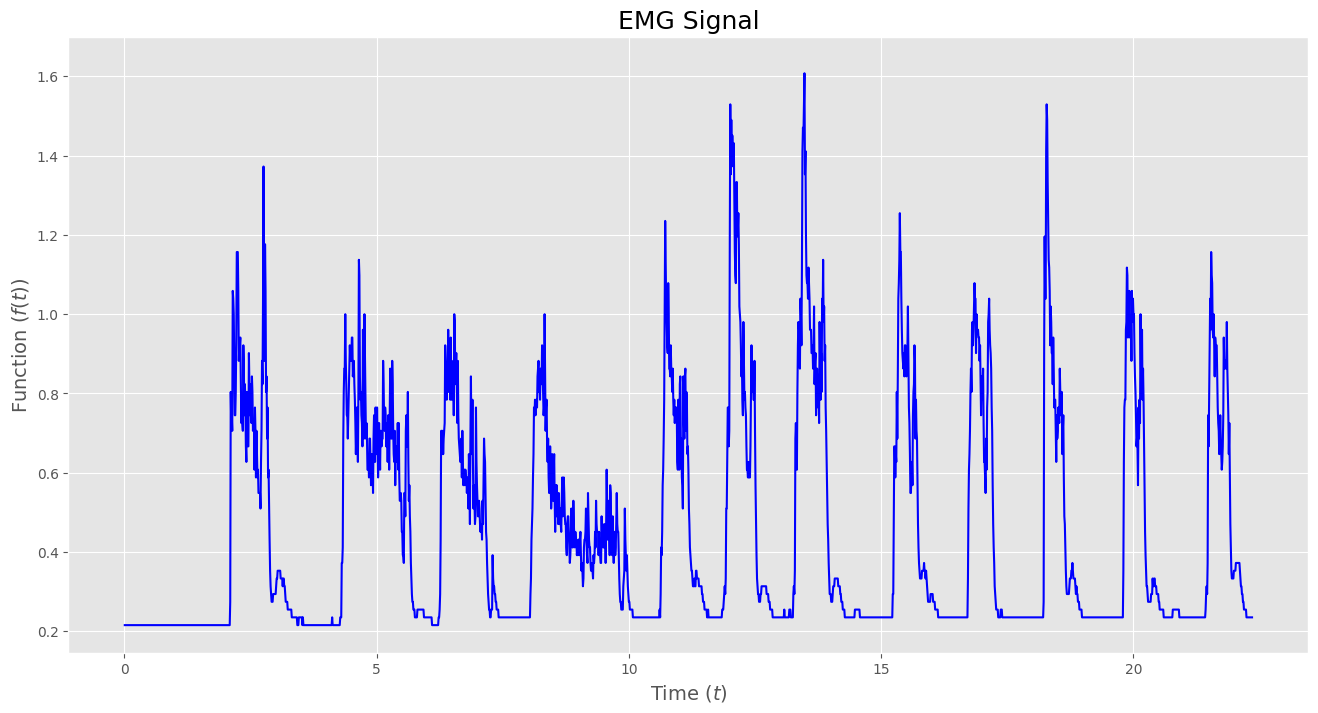

In [4]:
plt.style.use('ggplot')
plt.figure(figsize = (16, 8))
plt.title(r'EMG Signal', size=18)
plt.plot(df["0"], df["0.21569"],'b')
plt.ylabel(r'Function $(f(t))$', size=14)
plt.xlabel(r'Time $(t)$', size=14)
plt.ylim(top = 1.7)
plt.xlim()
plt.show()

## Ploynomial Function

In [5]:
poly = PolynomialFeatures(degree = 7)
X_poly = poly.fit_transform(t_2)
poly.fit(X_poly, sig_2)
lin2 = LinearRegression()
lin2.fit(X_poly, sig_2)

LinearRegression()

## Gradient Descent

In [37]:
def gradient_descent(start, y, X, learn_rate, max_iter, tol=0.001):
  steps = [start] 
  x = start
  for _ in range(max_iter):
    if x not in X:
      diff = 0
    else:  
      diff = -learn_rate*y[X.index(round(x,2))] 
    x = float('{0:.2f}'.format(x - diff))
    steps.append(x) 
  return steps, x

In [68]:
gradient = gradient_descent(9.5, sig, t, 0.2, 101)
new_time = sorted(set(gradient[0]))
new_gradient = [lin2.predict(poly.fit_transform(t_2)).tolist()[t.index(new_time[:len(new_time)-1][i])][0]
for i in range(len(new_time[:len(new_time)-1]))]

## Stochastic Gradient Descent

In [136]:
def sgd(x,y,lr,it):
    x = np.array(x)
    ones = np.ones(shape=(x.shape[0],1))
    x = np.concatenate((ones, x.reshape(-1,1)), axis=1)
    y = np.array(y)
    W = np.zeros(shape=(x.shape[1],1))
    all_W = list()
    for i in range(it):
        y_p = x @ W
        dW = np.dot(x.T, y_p - y)
        W = W - lr * dW
        all_W.append(W)
    return all_W

poly_list = [lin2.predict(poly.fit_transform(t_2)).tolist()[i][0]
for i in range(len(t))]

stoch_gd = sgd(new_time,new_gradient,0.01,10)
stoch_gd = np.array(stoch_gd)[0][1] - np.array(stoch_gd)[0][0]

## Plot Functions

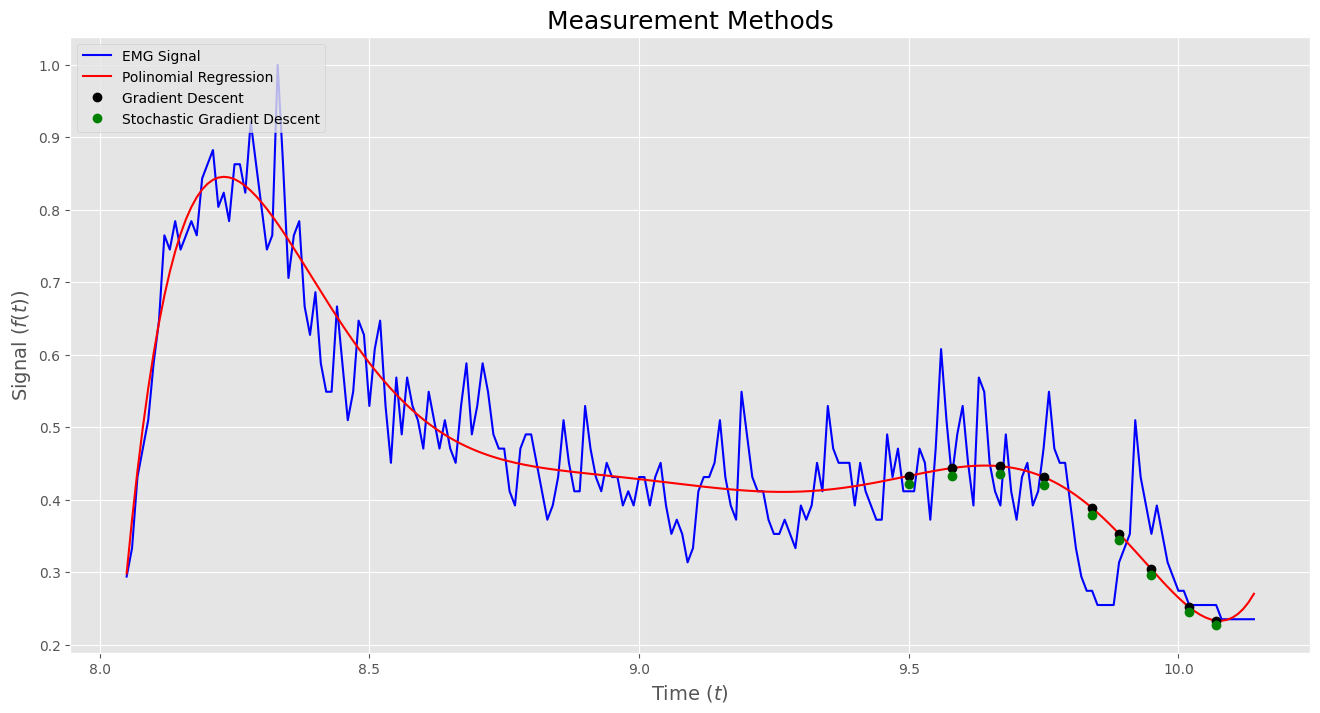

In [214]:
plt.style.use('ggplot')
plt.figure(figsize = (16, 8))
plt.title('Measurement Methods', size=18)
plt.plot(t,sig,'b', label=r'EMG Signal')
plt.plot(t_2, lin2.predict(poly.fit_transform(t_2)),'r', label=r'Polinomial Regression')
plt.plot(new_time[:len(new_time)-2], new_gradient[:len(new_gradient)-1], 'ko', label=r'Gradient Descent')
plt.plot(new_time[:len(new_time)-2], stoch_gd[:len(new_gradient)-1].tolist(), 'go', label=r'Stochastic Gradient Descent')

plt.ylabel(r'Signal $(f(t))$', size=14)
plt.xlabel(r'Time $(t)$', size=14)
plt.legend(loc = "upper left")
#plt.ylim(top = 1.2)
plt.show()

## Genetic Algorithm

In [210]:
class Individual:

    def __init__(self, c, d):
        self.values = [[rand.normal() for _ in range(c + 1)] for _ in range(d)]
        self.fitness = None

    def evaluate(self, lookupTable):
        self.fitness = 0
        for x in lookupTable.keys():
            image = 0
            for variable in self.values:
                for power, coefficient in enumerate(variable):
                    image += coefficient * x ** power
            target = lookupTable[x]
            mse = (target - image) ** 2
            self.fitness += mse

    def mutate(self, rate):
        self.values = [[rand.uniform(c - rate, c + rate) for c in variable]
                       for variable in self.values]

    def display(self):
        intercept = 0
        print ('Polynomial form')
        print ('---------------')
        for index, variable in enumerate(self.values):
            intercept += variable[0]
            for power, coefficient in enumerate(variable[1:]):
                print (str(coefficient) + ' * ' + 'x' + str(index) + \
                       '**' + str(power+1) + ' + ')
        print (intercept)

    def roundCoefficients(self):
        self.values = [[round(value, 1) for value in variable]
                       for variable in self.values] 
                
class Population:
    
    def __init__(self, c, d, size=100):
        self.individuals = [Individual(c, d) for _ in range(size)]
        self.best = [Individual(c, d)]
        self.rate = 0.1
        plt.ion()
        
    def sort(self):
        self.individuals = sorted(self.individuals, key=lambda indi: indi.fitness)
                    
    def evaluate(self, lookupTable):
        for indi in self.individuals:
            indi.evaluate(lookupTable)

    def enhance(self, lookupTable):
        newIndividuals = []
        for individual in self.individuals[:10]:
            newIndividuals.append(deepcopy(individual))
            for _ in range(4):
                newIndividual = deepcopy(individual)
                newIndividual.mutate(self.rate)
                newIndividuals.append(newIndividual)
        self.individuals = newIndividuals
        self.evaluate(lookupTable)
        self.sort()
        self.best.append(self.individuals[0])
        if self.best[-1].fitness == self.best[-2].fitness:
            self.rate += 0.01
        else:
            self.rate = 0.1
        
    def plot2D(self, x, y, generation):
        assert len(self.best[-1].values) == 1, 'Data points are not of dimension 1.'
        X = np.linspace(min(x), max(x))
        Y = [sum(c * x ** p
          for p, c in enumerate(variable))
          for variable in self.best[-1].values
          for x in X]
        plt.clf()
        plt.figure(figsize = (16, 8))
        plt.plot(X, Y, c='blue', label=r'Genetic Algorithm')
        plt.scatter(x, y, c='red', s=100, label=r'Signal')
        plt.title('Generation : ' + str(generation) + ' / ' +
                  'Error : ' + str(self.best[-1].fitness))
        plt.ylabel(r'Signal $(f(t))$', size=14)
        plt.xlabel(r'Time $(t)$', size=14)
        plt.legend(loc = "upper left")
        plt.pause(5e-324)

<Figure size 640x480 with 0 Axes>

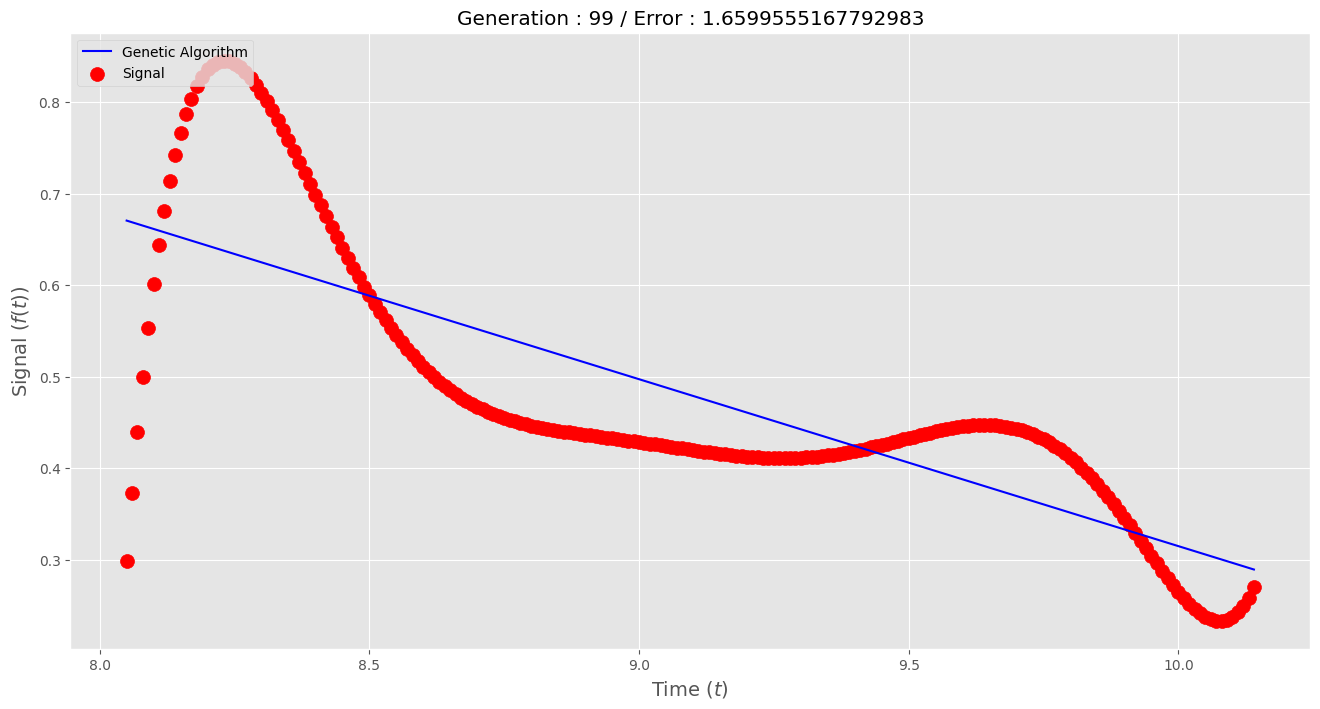

In [212]:
new_df = pd.DataFrame({'X': t, 'Y' : poly_list})

plt.style.use('ggplot')
startTime = time.time()
function = 'Y'

lookupTable = {}
for i, record in new_df.iterrows():
    key = record['X']
    lookupTable[key] = record[function]

generations = 100
degrees = 1
variables = 1

polynomials = Population(degrees, variables)
polynomials.evaluate(lookupTable)
polynomials.sort()

for g in range(generations):
    polynomials.enhance(lookupTable)

polynomials.plot2D(t_2, lin2.predict(poly.fit_transform(t_2)), g)